
Valid data range for SWE:
Min value: 1.0
Max value: 32767.0
Number of valid points: 250515

Chosen point data:
Latitude: 49.9875
Longitude: -118.5875
Value at point: [0.]
Found better point:
Latitude: 46.00416666666666
Longitude: -121.85416666666669
Value at point: [87.]
Found 18 SWE files:
  - 20250601_SWE_final.nc
  - 20250602_SWE_final.nc
  - 20250603_SWE_final.nc
  - 20250604_SWE_final.nc
  - 20250605_SWE_final.nc
  - 20250606_SWE_final.nc
  - 20250607_SWE_final.nc
  - 20250608_SWE_final.nc
  - 20250609_SWE_final.nc
  - 20250610_SWE_final.nc
  - 20250611_SWE_final.nc
  - 20250612_SWE_final.nc
  - 20250613_SWE_final.nc
  - 20250614_SWE_final.nc
  - 20250615_SWE_final.nc
  - 20250616_SWE_final.nc
  - 20250617_SWE_final.nc
  - 20250618_SWE_final.nc
Processed 20250601_SWE_final.nc, value: [87.]
Processed 20250602_SWE_final.nc, value: [58.]
Processed 20250603_SWE_final.nc, value: [39.]
Processed 20250604_SWE_final.nc, value: [12.]
Processed 20250605_SWE_final.nc, value: [0.]
Processed 

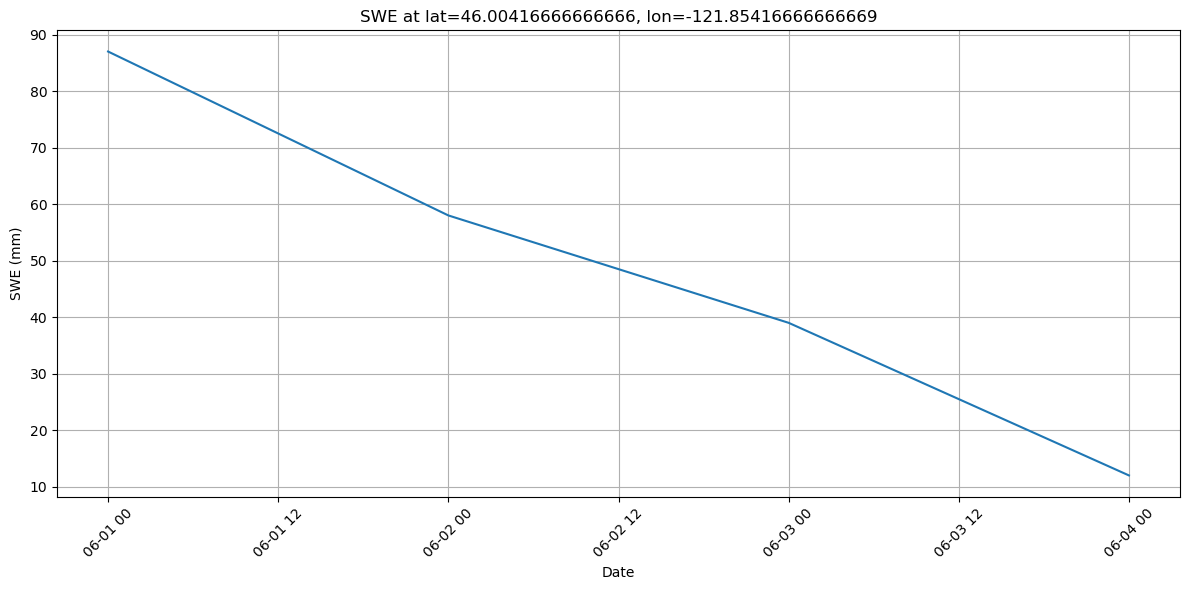


SWE Statistics:
count     4.000000
mean     49.000000
std      31.591139
min      12.000000
25%      32.250000
50%      48.500000
75%      65.250000
max      87.000000
Name: SWE, dtype: float64

Valid data range for SD:
Min value: 0.0010000000474974513
Max value: 32.766998291015625
Number of valid points: 252680

Chosen point data:
Latitude: 49.9875
Longitude: -118.5875
Value at point: [0.]
Found better point:
Latitude: 46.00416666666666
Longitude: -121.85416666666669
Value at point: [0.209]
Found 18 SD files:
  - 20250601_SD_final.nc
  - 20250602_SD_final.nc
  - 20250603_SD_final.nc
  - 20250604_SD_final.nc
  - 20250605_SD_final.nc
  - 20250606_SD_final.nc
  - 20250607_SD_final.nc
  - 20250608_SD_final.nc
  - 20250609_SD_final.nc
  - 20250610_SD_final.nc
  - 20250611_SD_final.nc
  - 20250612_SD_final.nc
  - 20250613_SD_final.nc
  - 20250614_SD_final.nc
  - 20250615_SD_final.nc
  - 20250616_SD_final.nc
  - 20250617_SD_final.nc
  - 20250618_SD_final.nc
Processed 20250601_SD_final.nc, v

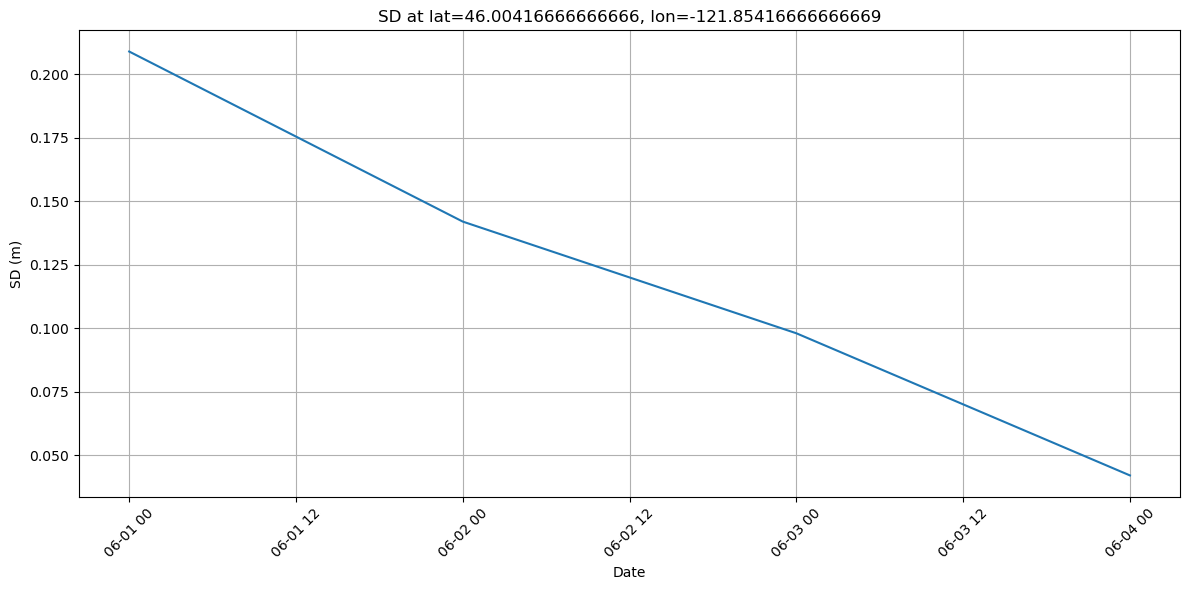


SD Statistics:
count    4.000000
mean     0.122750
std      0.070576
min      0.042000
25%      0.084000
50%      0.120000
75%      0.158750
max      0.209000
Name: SD, dtype: float64


In [13]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import numpy as np

def find_valid_coordinates(variable_type):
    # Read the first file to get coordinates
    files = [f for f in os.listdir("Archive") if f.endswith(f"{variable_type}_final.nc")]
    if not files:
        print(f"No {variable_type} files found!")
        return None, None
    
    # Read first file
    ds = xr.open_dataset(os.path.join("Archive", files[0]))
    
    # Find coordinates with non-NaN and non-zero values
    data = ds[variable_type].values
    valid_mask = (~np.isnan(data)) & (data > 0)  # Strictly greater than 0
    
    if not np.any(valid_mask):
        print(f"No valid non-zero data found in {variable_type} files!")
        return None, None
    
    # Get valid coordinates
    valid_lats = ds.lat.values[np.any(valid_mask, axis=(0, 2))]  # Any valid data in this lat
    valid_lons = ds.lon.values[np.any(valid_mask, axis=(0, 1))]  # Any valid data in this lon
    
    # Print some debugging info
    print(f"\nValid data range for {variable_type}:")
    print(f"Min value: {np.min(data[valid_mask])}")
    print(f"Max value: {np.max(data[valid_mask])}")
    print(f"Number of valid points: {np.sum(valid_mask)}")
    
    # Choose middle of valid range
    lat = valid_lats[len(valid_lats)//2]
    lon = valid_lons[len(valid_lons)//2]
    
    # Verify the chosen point has non-zero data
    point_data = ds[variable_type].sel(lat=lat, lon=lon, method='nearest').values
    print(f"\nChosen point data:")
    print(f"Latitude: {lat}")
    print(f"Longitude: {lon}")
    print(f"Value at point: {point_data}")
    
    if point_data <= 0:
        print("Warning: Chosen point has zero or negative value!")
        # Try to find a point with positive value
        for lat in valid_lats:
            for lon in valid_lons:
                point_data = ds[variable_type].sel(lat=lat, lon=lon, method='nearest').values
                if point_data > 0:
                    print(f"Found better point:")
                    print(f"Latitude: {lat}")
                    print(f"Longitude: {lon}")
                    print(f"Value at point: {point_data}")
                    return lat, lon
    
    return lat, lon

def process_and_plot_data(variable_type, lat, lon):
    # Get all final files for the variable type (SWE or SD)
    files = [f for f in os.listdir("Archive") if f.endswith(f"{variable_type}_final.nc")]
    files.sort()  # Sort to ensure chronological order
    
    print(f"Found {len(files)} {variable_type} files:")
    for f in files:
        print(f"  - {f}")
    
    # Initialize list to store data
    data_list = []
    
    # Read and concatenate all files
    for file in files:
        ds = xr.open_dataset(os.path.join("Archive", file))
        # Select the specific location
        data = ds[variable_type].sel(lat=lat, lon=lon, method='nearest')
        data_list.append(data)
        print(f"Processed {file}, value: {data.values}")
    
    # Concatenate all data
    combined_data = xr.concat(data_list, dim='time')
    
    # Convert to pandas for easier plotting
    df = combined_data.to_dataframe()
    
    # Filter for June 1-18
    df = df['2025-06-01':'2025-06-18']
    
    # Remove any zero values
    df = df[df[variable_type] > 0]
    
    print(f"\nData for {variable_type}:")
    print(df)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[variable_type])
    plt.title(f'{variable_type} at lat={lat}, lon={lon}')
    plt.xlabel('Date')
    plt.ylabel(f'{variable_type} ({combined_data.units})')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df

# Find valid coordinates for SWE
swe_lat, swe_lon = find_valid_coordinates('SWE')
if swe_lat is not None and swe_lon is not None:
    # Process and plot SWE
    swe_df = process_and_plot_data('SWE', swe_lat, swe_lon)
    print("\nSWE Statistics:")
    print(swe_df['SWE'].describe())

# Find valid coordinates for SD
sd_lat, sd_lon = find_valid_coordinates('SD')
if sd_lat is not None and sd_lon is not None:
    # Process and plot SD
    sd_df = process_and_plot_data('SD', sd_lat, sd_lon)
    print("\nSD Statistics:")
    print(sd_df['SD'].describe())






In [1]:
import xarray as xr
import os

from load_data import load_SNODAS
from load_data import load_CaPA

# Load data
#swe_ds = load_SNODAS('2025-06-01', '2025-06-08', variable='SWE', lat=None, lon=None)

#swe_ds.to_netcdf("SWE_total_teeest_0601_0608.nc")

#ds_CaPA = xr.open_dataset(r'C:\_LOCALdata\Downscaling_Bias_Correction\lwf_calc\Archive_CaPA\Capa_HRDPA_Daily_Precip_20250401_to_20250604.nc')
#ds_SNODAS = xr.open_dataset(r'C:\_LOCALdata\Downscaling_Bias_Correction\lwf_calc\SWE_total_teeest_0601_0608.nc')
# Or load all data for a date range
#CaPA_ds = load_CaPA('2025-06-01', '2025-06-04')

SWE_ds = load_SNODAS('2025-06-01', '2025-06-04', variable='SWE')

SWE_ds.to_netcdf("SWE_0601_0604.nc")










In [6]:
import xarray as xr
import os
from datetime import datetime

from resample import resample_SNODAS_to_CaPA

SWE_ds = xr.open_dataset(r'C:\_LOCALdata\Downscaling_Bias_Correction\lwf_calc\SWE_0601_0604.nc')
CaPA_ds = xr.open_dataset(r'C:\_LOCALdata\Downscaling_Bias_Correction\lwf_calc\CaPA_ds_0601_0604.nc')
upscaled_SWE, CaPA_resampled = resample_SNODAS_to_CaPA(SWE_ds, CaPA_ds)



upscaled_SWE.to_netcdf("upscaled_SWE_0601_0604.nc")
CaPA_resampled.to_netcdf("CaPA_resampled_0601_0604.nc")




In [4]:
lwf_df = lwf_dataset.to_dataframe()

In [3]:
import xarray as xr
from lwf import calculate_lwf

upscaled_SWE = xr.open_dataset(r'C:\_LOCALdata\Downscaling_Bias_Correction\lwf_calc\upscaled_SWE_0601_0604.nc')
CaPA_resampled = xr.open_dataset(r'C:\_LOCALdata\Downscaling_Bias_Correction\lwf_calc\CaPA_resampled_0601_0604.nc')


lwf_dataset, lwf_dataset_mm_day = calculate_lwf(upscaled_SWE, CaPA_resampled)

lwf_dataset.to_netcdf("lwf_dataset_0601_0604.nc")
lwf_dataset_mm_day.to_netcdf("lwf_dataset_mm_day_0601_0604.nc")












